# Librairies utiles

In [11]:
from bitarray import bitarray
import mmh3
import datetime
import numpy as np
import scipy.stats
import scipy.special
import pandas as pd
import geopandas as gpd
import contextily as cx
import random # Pour générer des nombres aléatoirement pour les fonctions de hachage
import copy
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

# Classe Bloom Filter

On propose un filtre qui, avant d'ajouter un élément, vérifie la présence de ce dernier au sein du filtre et incrémente un compteur d'éléments uniques. Ce compteur est par définition faussé par la tendance qu'à le filtre à faire des faux positifs, tendance qui dépend du niveau de remplissage du filtre (paramètres k et m étant fixés).

In [2]:
class BloomFilter(object):
 
    '''
    Class for Bloom filter, using murmur3 hash function
    '''
 
    def __init__(self, max_items, max_fp_prob):
        '''
        max_items : int
            Maximum number of items expected to be stored in bloom filter
        max_fp_prob : float
            False Positive probability threshold in decimal
        '''
        # Size of bit array to use
        self.size = self.get_size(max_items, max_fp_prob)
        
        # Number of hash functions to use
        self.hash_count = self.get_hash_count(self.size, max_items)
        
        # Random seeds of hash functions : permet de ne pas créer à chaque fois le même filtre (rigoureusement).
        self.seeds = random.sample(range(100), self.hash_count)
                
        # False possible probability in decimal
        self.fp_prob = 0 # Initialized to 0 because no items in the filter
 
        # Bit array of given size
        self.bit_array = bitarray(self.size)
        self.bit_array.setall(0) # Initialize all bits as 0
        
        # Number of items currently in the filter : increase by one each time we add an element
        self.unique_items = 0 # Initialized to 0
        
        # Usual (litterature) estimator for counting items : based on number of bits set to one in the filter. Estimate unique_items.
        self.estimate_items = 0 # Initialized to 0
        
        # Flipping probability
        self.flip_prob = 0 # Initialized at 0
        
        
    def check(self, item):
        '''
        Check for existence of an item in filter
        '''
        for i in self.seeds:
            digest = mmh3.hash(item, i) % self.size
            if self.bit_array[digest] == False:

                # if any of bit is False then,its not present
                # in filter
                # else there is probability that it exist
                return False
        return True


    def check_items(self, items):
        '''
        Check for existence in filter of items from an array of items
        '''
        return np.array([self.check(item) for item in items], dtype = bool)


    def add_w_check(self, item):
        '''
        Add an item in the filter if it is not already in filters
        '''
        if not self.check(item): # If filter says item not in filter, it is not, so add it
            digests = []
            for i in self.seeds:
                # Create digest for given item.
                # i work as seed to mmh3.hash() function
                # With different seed, digest created is different
                digest = mmh3.hash(item, i) % self.size
                digests.append(digest)

                # Set the bit True in bit_array
                self.bit_array[digest] = True
            
            # Update counter of unique items
            self.unique_items += 1
            
            # Update of false positive probability
            self.fp_prob = self.get_fp_prob(self.unique_items, self.size, self.hash_count)
            
            # Update the estimate of unique items
            self.estimate_items = int(np.log(1 - self.bit_array.count(1)/self.size)/(self.hash_count*np.log(1 - 1/self.size)))

    
    def add_items(self, items):
        '''
        Add in the filter items that are not already in filter, from an array of items
        '''
        # Find items that are not in filter for sure
        items_not_in_filter = items[~self.check_items(items)]
        
        # Add elements not in filter
        for item in items_not_in_filter:
            # Add an element without checking it
            digests = []
            for i in self.seeds:

                # create digest for given item.
                # i work as seed to mmh3.hash() function
                # With different seed, digest created is different
                digest = mmh3.hash(item, i) % self.size
                digests.append(digest)

                # set the bit True in bit_array
                self.bit_array[digest] = True
        
            # Update the counter of unique items
            self.unique_items += 1
        
        # Update of false positive probability
        self.fp_prob = self.get_fp_prob(self.unique_items, self.size, self.hash_count)
        
        # Update the estimate of unique items
        self.estimate_items = int(np.log(1 - self.bit_array.count(1)/self.size)/(self.hash_count*np.log(1 - 1/self.size)))
        
        
    @classmethod
    def get_size(self, n, p):
        '''
        Return the size of bit array(m) to used using
        following formula
        m = -(n * lg(p)) / (lg(2)^2)
        n : int
            number of items expected to be stored in filter
        p : float
            False Positive probability in decimal
        '''
        m = -(n * np.log(p))/(np.log(2)**2)
        return int(m)
 
    @classmethod
    def get_hash_count(self, m, n):
        '''
        Return the hash function(k) to be used using
        following formula
        k = (m/n) * lg(2)
 
        m : int
            size of bit array
        n : int
            number of items expected to be stored in filter
        '''
        k = (m/n) * np.log(2)
        return max(1, int(k))
    
    @classmethod
    def get_fp_prob(self, n_unique, m, k):
        '''
        Return the false positive probability using
        following formula
        fp = (1-(1-1/m)**(kn))**k
 
        m : int
            size of bit array
        n_unique : int
            number of unique items currently in the filter
        k : int
            number of hash functions
        '''
        # Cette forme n'est pas exacte, on pourrait ajouter la forme exacte issue de la littérature (modèle d'urnes) : longue à calculer ?
        p = (1-np.exp(-k*n_unique/m))**k
        return p

In [3]:
# Création de l'univers : on va piocher les éléments aléatoirement donc créer des trajectoires différentes pour le filtre
def creation_univers(s_max, p, n_t):
    
    #tirages_elements = np.array([np.arange(np.round(s_max/(1-p))) for t in range(n_t)]) # Chaque flux d'éléments est identique
    return np.array([np.array(random.sample(range(2*int(np.round(s_max/(1-p)))), k = int(np.round(s_max/(1-p)))))]*n_t)

# Origin-Destination Use Case

## Open Data Vélo Montréal

Lien vers le dataset utilisé : https://donnees.montreal.ca/ville-de-montreal/trajets-individuels-velo-enregistre-mon-resovelo

In [5]:
gdf = gpd.read_file(r"D:\users\RS\Bloom_Filter\trip5000\trip5000.json")

In [6]:
gdf

,stop,id_origine,start,length,purpose,n_coord,id,geometry
0,2013-06-25T16:34:16,52,2013-06-25T16:21:21,3163,Commute,511,52,"LINESTRING (-73.57748 45.50690, -73.57751 45.5..."
1,2013-07-25T14:40:06,2325,2013-07-25T14:37:42,1066,Courses,196,2325,"LINESTRING (-73.62897 45.46372, -73.62891 45.4..."
2,2013-07-25T14:43:12,2326,2013-07-25T14:19:15,5619,Courses,1036,2326,"LINESTRING (-73.58481 45.56786, -73.58153 45.5..."
3,2013-06-25T16:34:16,53,2013-06-25T16:21:20,3115,Commute,1403,53,"LINESTRING (-73.57748 45.50690, -73.57746 45.5..."
4,2013-06-26T13:00:05,56,2013-06-26T12:46:01,5376,Domicile-travail,1004,56,"LINESTRING (-73.60502 45.51903, -73.60487 45.5..."
...,...,...,...,...,...,...,...,...
4876,2015-07-04T17:19:31,28853,2015-07-04T17:10:45,1982,other,321,28853,"LINESTRING (-73.61841 45.53727, -73.61830 45.5..."
4877,2015-08-29T17:33:39,28859,2015-08-29T17:28:11,1456,Travail,460,28859,"LINESTRING (-73.66615 45.54782, -73.66594 45.5..."
4878,2015-08-30T16:16:31,28893,2015-08-30T15:40:30,1853,Magasinage,433,28893,"LINESTRING (-73.58151 45.52555, -73.58119 45.5..."
4879,2015-08-30T19:52:47,28904,2015-08-30T19:35:18,1521,Magasinage,441,28904,"LINESTRING (-73.57132 45.52061, -73.57111 45.5..."


In [79]:
# On agrège l'espace (on ne prend pas en compte le temps ici) : cela donne simplement 4 zones.
gdf['lon_O'] = gdf.geometry.apply(lambda x: round(x.coords[0][0], 0))
gdf['lon_D'] = gdf.geometry.apply(lambda x: round(x.coords[-1][0], 0))
gdf['lat_O'] = gdf.geometry.apply(lambda x: round(x.coords[0][1], 0))
gdf['lat_D'] = gdf.geometry.apply(lambda x: round(x.coords[-1][1], 0))

In [80]:
gdf

,stop,id_origine,start,length,purpose,n_coord,id,geometry,lon_O,lon_D,lat_O,lat_D
0,2013-06-25T16:34:16,52,2013-06-25T16:21:21,3163,Commute,511,52,"LINESTRING (-73.57748 45.50690, -73.57751 45.5...",-74.0,-74.0,46.0,46.0
1,2013-07-25T14:40:06,2325,2013-07-25T14:37:42,1066,Courses,196,2325,"LINESTRING (-73.62897 45.46372, -73.62891 45.4...",-74.0,-74.0,45.0,45.0
2,2013-07-25T14:43:12,2326,2013-07-25T14:19:15,5619,Courses,1036,2326,"LINESTRING (-73.58481 45.56786, -73.58153 45.5...",-74.0,-74.0,46.0,46.0
3,2013-06-25T16:34:16,53,2013-06-25T16:21:20,3115,Commute,1403,53,"LINESTRING (-73.57748 45.50690, -73.57746 45.5...",-74.0,-74.0,46.0,46.0
4,2013-06-26T13:00:05,56,2013-06-26T12:46:01,5376,Domicile-travail,1004,56,"LINESTRING (-73.60502 45.51903, -73.60487 45.5...",-74.0,-74.0,46.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4876,2015-07-04T17:19:31,28853,2015-07-04T17:10:45,1982,other,321,28853,"LINESTRING (-73.61841 45.53727, -73.61830 45.5...",-74.0,-74.0,46.0,46.0
4877,2015-08-29T17:33:39,28859,2015-08-29T17:28:11,1456,Travail,460,28859,"LINESTRING (-73.66615 45.54782, -73.66594 45.5...",-74.0,-74.0,46.0,46.0
4878,2015-08-30T16:16:31,28893,2015-08-30T15:40:30,1853,Magasinage,433,28893,"LINESTRING (-73.58151 45.52555, -73.58119 45.5...",-74.0,-74.0,46.0,46.0
4879,2015-08-30T19:52:47,28904,2015-08-30T19:35:18,1521,Magasinage,441,28904,"LINESTRING (-73.57132 45.52061, -73.57111 45.5...",-74.0,-74.0,46.0,46.0


In [81]:
gdf.id.nunique()

4881

In [82]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

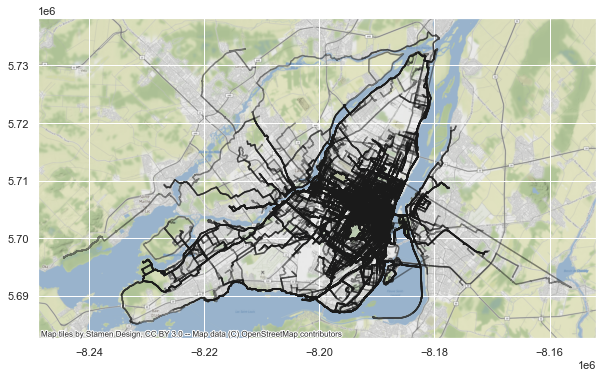

In [279]:
gdf_wm = gdf.to_crs(epsg=3857)
ax = gdf_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=gdf_wm.crs)

## Comptage par OD "aggrégées

In [118]:
count_OD = gdf[['lon_O', 'lat_O', 'lon_D', 'lat_D', 'id']].groupby(['lon_O', 'lat_O', 'lon_D', 'lat_D']).count().reset_index().rename(columns = {'id':'n_OD'})

In [119]:
count_OD

,lon_O,lat_O,lon_D,lat_D,n_OD
0,-74.0,45.0,-74.0,45.0,442
1,-74.0,45.0,-74.0,46.0,362
2,-74.0,45.0,-73.0,45.0,6
3,-74.0,45.0,-73.0,46.0,3
4,-74.0,46.0,-74.0,45.0,405
5,-74.0,46.0,-74.0,46.0,3581
6,-74.0,46.0,-73.0,45.0,2
7,-74.0,46.0,-73.0,46.0,27
8,-73.0,45.0,-74.0,45.0,6
9,-73.0,45.0,-74.0,46.0,4


In [86]:
count_OD.n_OD.unique()

array([ 442,  362,    6,    3,  405, 3580,    2,   27,    4,    1,   30,
          8], dtype=int64)

In [78]:
count_OD[count_OD.n_OD == 169]

,lon_O,lat_O,lon_D,lat_D,n_OD
56,-73.6,45.5,-73.6,45.6,209


In [120]:
count_O = gdf[['lon_O', 'lat_O', 'id']].groupby(['lon_O', 'lat_O']).count().reset_index().rename(columns = {'id':'n_O'})

In [121]:
count_O

,lon_O,lat_O,n_O
0,-74.0,45.0,813
1,-74.0,46.0,4015
2,-73.0,45.0,11
3,-73.0,46.0,42


In [122]:
count_O.n_O.unique()

array([ 813, 4015,   11,   42], dtype=int64)

In [123]:
count_D = gdf[['lon_D', 'lat_D', 'id']].groupby(['lon_D', 'lat_D']).count().reset_index().rename(columns = {'id':'n_D'})

In [124]:
count_D

,lon_D,lat_D,n_D
0,-74.0,45.0,857
1,-74.0,46.0,3977
2,-73.0,45.0,9
3,-73.0,46.0,38


In [91]:
count_D.n_D.unique()

array([ 857, 3976,    9,   38], dtype=int64)

## Compter les ID : OD, O et D, avec les Bloom filters

In [138]:
# Lat/Lon de l'OD la plus fréquentée
OD_max = count_OD[count_OD.n_OD == count_OD.n_OD.max()].values

# Trajectoires qui font cette OD
gdf_OD_max = gdf[(gdf.lon_O == OD_max[0][0]) & (gdf.lat_O == OD_max[0][1]) & (gdf.lon_D == OD_max[0][2]) & (gdf.lat_D == OD_max[0][3])]

# Identités qui font cette OD, cette O, et cette D
ID_OD = gdf_OD_max.id.unique() # Id qui font l'OD
ID_O = gdf[(gdf.lon_O == OD_max[0][0]) & (gdf.lat_O == OD_max[0][1])].id.unique()
ID_D = gdf[(gdf.lon_D == OD_max[0][2]) & (gdf.lat_D == OD_max[0][3])].id.unique()

In [184]:
ID_OD

array([   52,  2326,    53, ..., 28893, 28904, 28938], dtype=int64)

In [140]:
ID_O

array([   52,  2326,    53, ..., 28893, 28904, 28938], dtype=int64)

In [141]:
ID_D

array([   52,  2326,    53, ..., 28893, 28904, 28938], dtype=int64)

In [371]:
# Création du filtre
max_items = 5000
BF = BloomFilter(max_items, 0.01)

# Paramètres
print('Taille : ', BF.size, ' Nombre de fonctions de hachage : ', BF.hash_count)

Taille :  47925  Nombre de fonctions de hachage :  6


In [372]:
# Paramètres filtres
m = 47925
k = 6

In [373]:
# Estimateur de l'erreur de comptage et variance associée
mean_error_count, var_error_count = [0], [0]
fp_probs = BF.get_fp_prob(np.arange(0, 2*max_items+1), BF.size, BF.hash_count)
for l in range(2*max_items):
    mean_error_count.append(np.sum((fp_probs/(1-fp_probs))[:l+1])) # Temps d'attente (loi géométrique)
    var_error_count.append(np.sum((fp_probs/((1-fp_probs)**2))[:l+1])) # Variance loi géométrique
std_error_count = np.sqrt(var_error_count)

In [374]:
# Création de 100 filtres pour faire moyenne & variance des estimateurs
n_t = 100000 # Nombre de filtres & flux d'éléments

# Filtres différents car les éléments ne varient pas
BFOs = [BloomFilter(max_items, 0.01) for t in range(n_t)]
BFD2s = [BloomFilter(max_items, 0.01) for t in range(n_t)] # Inutile ici ? Non, comparaison avec intersection de filtres sans BLIP
BFDs = copy.deepcopy(BFOs) # Important pour faire fonctionner la méthode par intersection ? Avoir des filtres avec les mêmes fonctions de hachage ?
BFODs = [BloomFilter(max_items, 0.01) for t in range(n_t)]

In [375]:
# Remplissage de 100 filtres origines et estimation de cardinal
countersO = np.array([])
corrected_countersO = np.array([])
literature_estimateO = np.array([])
for BFO in BFOs:
    for element in ID_O:
        BFO.add_w_check(element)
    counter = BFO.unique_items
    countersO = np.append(countersO, counter)
    corrected_countersO = np.append(corrected_countersO, counter + mean_error_count[counter])
    literature_estimateO = np.append(literature_estimateO, BFO.estimate_items)

In [376]:
# Erreurs algébriques et RMSE : proposition vs littérature
MBEO = np.mean(corrected_countersO - ID_O.shape[0])
MBEO_std = np.std(corrected_countersO - ID_O.shape[0])
MBEO_literature = np.mean(literature_estimateO - ID_O.shape[0])
MBEO_literature_std = np.std(literature_estimateO - ID_O.shape[0])
RMSEO = np.sqrt(np.mean((corrected_countersO - ID_O.shape[0])**2))
RMSEO_literature = np.sqrt(np.mean((literature_estimateO - ID_O.shape[0])**2))
print(MBEO, '+/-', MBEO_std, RMSEO, MBEO_literature, '+/-', MBEO_literature_std, RMSEO_literature)

-0.01100087915815724 +/- 1.6252449581795492 1.6252821888614597 -1.79855 +/- 14.037160250474454 14.151913298208125


On a rejoué l'expérience de l'article précédent sur cet exemple, et on retrouve des résultats similaires.

In [377]:
# Remplissage de 100 filtres OD et estimation de cardinal
n_D = ID_D.shape[0] # Nombre d'éléments vus sur la destination (supposé accessible)
countersOD = np.array([]) # Compteur non corrigé (ou alors corrigé avec + oubliés - oubliés, cf hypothèse plus loin...)
corrected_countersOD = np.array([]) # Ici on va rajouter des éléments, ceux qui sont oubliés par BFOD lors des ajouts successifs (article précédent)
corrected_countersOD2 = np.array([]) # Ici on va juste enlever des éléments ajoutés en trop à cause de BFO, avec une estimation grossière.
literature_estimateOD = np.array([])
for BFOD in BFODs:
    for element in ID_D:
        if BFO.check(element) == True:
            BFOD.add_w_check(element)
    counter = BFOD.unique_items
    countersOD = np.append(countersOD, counter)
    corrected_countersOD = np.append(corrected_countersOD, counter + mean_error_count[counter])
    corrected_countersOD2 = np.append(corrected_countersOD2, counter - mean_error_count[BFO.unique_items] + mean_error_count[counter])
    literature_estimateOD = np.append(literature_estimateOD, BFOD.estimate_items)

In [378]:
# Erreurs algébriques et RMSE : proposition vs littérature
MBEOD = np.mean(corrected_countersOD - ID_OD.shape[0])
MBEOD_std = np.std(corrected_countersOD - ID_OD.shape[0])
MBEOD_literature = np.mean(literature_estimateOD - ID_OD.shape[0])
MBEOD_literature_std = np.std(literature_estimateOD - ID_OD.shape[0])
RMSEOD = np.sqrt(np.mean((corrected_countersOD - ID_OD.shape[0])**2))
RMSEOD_literature = np.sqrt(np.mean((literature_estimateOD - ID_OD.shape[0])**2))
print(MBEOD, '+/-', MBEOD_std, RMSEOD, MBEOD_literature, '+/-', MBEOD_literature_std, RMSEOD_literature)

0.9807602295131329 +/- 1.1739233150124881 1.5297014667328273 -0.5243 +/- 12.49847468733685 12.509466815176417


L'erreur de notre estimateur est un peu plus élevée, et algébriquement positive : cela s'explique par la non prise en compte des "ajouts en trop" à cause des faux positifs de BFO. On a seulement pris en compte les "oublis" de BFOD avec notre estimateur classique, et donc on corrige trop fort.

In [379]:
MBEOD_non_corrigee = np.mean(countersOD - ID_OD.shape[0])
MBEOD_non_corrigee_std = np.std(countersOD - ID_OD.shape[0])
RMSEOD_non_corrigee = np.sqrt(np.mean((countersOD - ID_OD.shape[0])**2))
print(MBEOD_non_corrigee, '+/-', MBEOD_non_corrigee_std, RMSEOD_non_corrigee)

-0.36429 +/- 1.1713166932559274 1.2266580615640204


On suppose qu'on en a ajouté en trop autant qu'on en a oublié : cela revient à ne pas corriger le compteur incrémenté dans BFOD. C'est déjà meilleur.

In [388]:
MBEOD2 = np.mean(corrected_countersOD2 - ID_OD.shape[0])
MBEOD2_std = np.std(corrected_countersOD2 - ID_OD.shape[0])
RMSEOD2 = np.sqrt(np.mean((corrected_countersOD2 - ID_OD.shape[0])**2))
print(MBEOD2, '+/-', MBEOD2_std, RMSEOD2)

-1.6500602181236463 +/- 1.1739233150124881 2.0250418941256907


Ici on a corrigé en enlevant le nombre de faux positifs fait par BFO au cours de son remplissage et en rajoutant le nombre de faux positifs faits pas BFOD au cours de son remplissage.

In [382]:
# Comparaison avec intersection de filtres
# Remplissage de 100 filtres origines et estimation de cardinal
countersD = np.array([])
corrected_countersD = np.array([])
literature_estimateD = np.array([])
for BFD in BFDs:
    for element in ID_D:
        BFD.add_w_check(element)
    counter = BFD.unique_items
    countersD = np.append(countersD, counter)
    corrected_countersD = np.append(corrected_countersD, counter + mean_error_count[counter])
    literature_estimateD = np.append(literature_estimateD, BFD.estimate_items)

In [383]:
literature_intersectOD = np.array([literature_estimateO[l] + literature_estimateD[l] \
                                   + (m/k)*np.log(1 - (BFOs[l].bit_array | BFDs[l].bit_array).count(1)/m) for l in range(n_t)])

In [389]:
print(np.mean(literature_intersectOD - ID_OD.shape[0]), '+/-', np.std(literature_intersectOD - ID_OD.shape[0]))

-2.43754659098677 +/- 12.739304901151826


In [390]:
print(np.sqrt(np.mean((literature_intersectOD - ID_OD.shape[0])**2)))

12.970409505784392


In [192]:
# Création du filtre
max_items = 17000
BF = BloomFilter(max_items, 0.01)

# Paramètres
print('Taille : ', BF.size, ' Nombre de fonctions de hachage : ', BF.hash_count)

Taille :  162945  Nombre de fonctions de hachage :  6


In [15]:
# Estimateur de l'erreur de comptage et variance associée
mean_error_count, var_error_count = [0], [0]
fp_probs = BF.get_fp_prob(np.arange(0, 2*max_items+1), BF.size, BF.hash_count)
for l in range(2*max_items):
    mean_error_count.append(np.sum((fp_probs/(1-fp_probs))[:l+1])) # Temps d'attente (loi géométrique)
    var_error_count.append(np.sum((fp_probs/((1-fp_probs)**2))[:l+1])) # Variance loi géométrique
std_error_count = np.sqrt(var_error_count)

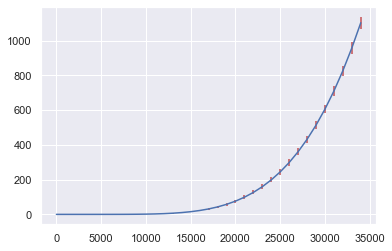

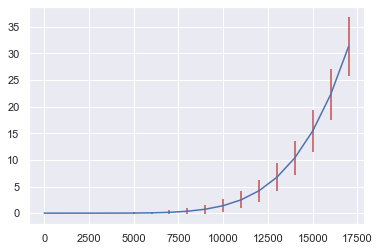

In [194]:
# Visualisation des estimateurs : errorbar
plt.figure()
plt.errorbar(np.arange(0, 2*max_items+1, 1000), np.array(mean_error_count)[0:2*max_items+1:1000], std_error_count[0:2*max_items+1:1000], \
             ecolor = 'r')
plt.show()

plt.figure()
plt.errorbar(np.arange(0, max_items+1, 1000), np.array(mean_error_count)[0:max_items+1:1000], std_error_count[0:max_items+1:1000], \
             ecolor = 'r')
plt.show()

In [109]:
fp_probs[25000] # Se faire une idée des valeurs de probabilités de faux positifs quand on dépasse trop le remplissage max prévu

0.047455965100180436

Tirage sans remise dans un univers U tel que |U| >> s_max, pour simuler p(s) = 1, pour tout s.

C'est donc un cas à traiter à part (tirage sans remise).

Cela dit, ce n'est pas un cas réaliste : car dans un cas pareil, on sait que si un check vaut 1, le filtre se trompe à coup sur, donc il faudrait corriger le compteur de 1 à chaque check égal à 1... Aucune erreur.

In [83]:
def remplissage_unique(BF, elements, estimateur):

    # Compteurs d'éléments au cours du temps
    count_unique_elements = [0] # Notre compteur pas corrigé
    literature_estimate_count = [0] # Estimateur littérature
    corrected_counter = [0] # Compteur corrigé

    # Nombre d'éléments oubliés (faux positifs)
    error_on_count = [0]
    
    # Erreur des estimateurs
    error_corrected_counter = [0]
    error_literature_estimate = [0]

    # Ajout des éléments dans le filtre, un par un
    i = 0
    while BF.unique_items < max_items:
        element = elements[i]
        BF.add_w_check(element) # Ajout de l'élément (modifie le filtre seulement si check negatif)
        if BF.unique_items == count_unique_elements[-1]: # On ne l'a pas ajouté : erreur (faux positif).
            error_on_count[-1] += 1 # Mon niveau de remplissage n'a pas changé, mais l'erreur a augmenté de 1.
        else: # On l'a ajouté sans faire d'erreur
            count_unique_elements.append(BF.unique_items)
            literature_estimate_count.append(BF.estimate_items)
            error_on_count.append(error_on_count[-1]) # Le niveau de remplissage change, mais l'erreur n'augmente pas
            corrected_counter.append(count_unique_elements[-1] + estimateur[BF.unique_items]) # On ajoute l'estimateur qu'on a fait pour corriger l'erreur de comptage
            error_corrected_counter.append(i+1 - corrected_counter[-1])
            error_literature_estimate.append(i+1 - literature_estimate_count[-1]) # Si on dit que l'estimateur estime le compteur : BF.estimate_items - BF.unique_items
        i += 1
    
    return count_unique_elements, literature_estimate_count, error_on_count, error_corrected_counter, error_literature_estimate, [i]*(BF.unique_items+1)

In [ ]:
n_t = 1000 # Nombre de filtres & flux d'éléments

# Combinaisons possibles dans (filtres différents/identiques, flux d'éléments différents/identiques)
# Combinaison qui semble la plus logique : filtres identiques (copies d'un même filtre), et flux d'éléments différents

tirages_elements = np.array([np.array(random.sample(range(100000), k = 20000)) for t in range(n_t)]) # Elements différents dans chaque flux, uniques (sample)
#tirages_elements = np.array([np.arange(20000) for t in range(n_t)]) # Chaque flux d'éléments est identique

BFs = [copy.deepcopy(BF) for t in range(n_t)] # Filtres identiques : faire varier les éléments
#BFs = [BloomFilter(max_items, 0.01) for t in range(n_t)] # Filtres différents : on peut ne pas faire varier les éléments

In [ ]:
resultats_tirages = []
for t in range(n_t):
    resultats_tirages.append(remplissage_unique(BFs[t], tirages_elements[t, :], mean_error_count))
resultats_tirages = np.array(resultats_tirages)

In [146]:
np.save('Results_1par1_p=1', resultats_tirages)

Différents cas pour l'univers U :

    - |U| >~= s_max : p(s_max) ~= 0, cas peu réaliste.
    - |U| = (1/0.8)*s_max : p(s_max) ~= 0.2
    - |U| = (1/0.6)*s_max : p(s_max) ~= 0.4
    - |U| = (1/0.4)*s_max : p_smax ~= 0.6
    - |U| = (1/0.2)*s_max : p_smax ~= 0.8

In [22]:
# Création de l'univers : on va piocher les éléments aléatoirement donc créer des trajectoires différentes pour le filtre
def creation_univers(s_max, p, n_t):
    
    #tirages_elements = np.array([np.arange(np.round(s_max/(1-p))) for t in range(n_t)]) # Chaque flux d'éléments est identique
    return np.array([np.array(random.sample(range(2*int(np.round(s_max/(1-p)))), k = int(np.round(s_max/(1-p)))))]*n_t)

In [222]:
def remplissage_tirage(BF, elements, estimateur, max_items):

    # Compteurs d'éléments au cours du temps
    count_unique_elements = [0] # Notre compteur pas corrigé
    literature_estimate_count = [0] # Estimateur littérature
    corrected_counter = [0] # Compteur corrigé

    # Nombre d'éléments oubliés (faux positifs)
    error_on_count = [0]
    
    # Erreur des estimateurs
    error_corrected_counter = [0]
    error_literature_estimate = [0]

    # Ajout des éléments dans le filtre, un par un, avec tirage uniforme dans l'univers
    elements_seen = []
    i = 0
    while BF.unique_items < max_items:
        element = random.sample(elements, 1)[0]
        BF.add_w_check(element) # Ajout de l'élément (modifie le filtre seulement si check negatif)
        if element not in elements_seen: # Si on ne l'a pas vu (si on l'a déjà vu, il ne sera pas ajouté, pas d'erreur).
            if BF.unique_items == count_unique_elements[-1]: # On ne l'a pas ajouté : erreur (faux positif).
                error_on_count[-1] += 1 # Mon niveau de remplissage n'a pas changé, mais l'erreur a augmenté de 1.
            else: # On l'a ajouté sans faire d'erreur
                count_unique_elements.append(BF.unique_items)
                literature_estimate_count.append(BF.estimate_items)
                error_on_count.append(error_on_count[-1]) # Le niveau de remplissage change, mais l'erreur n'augmente pas
                corrected_counter.append(count_unique_elements[-1] + estimateur[BF.unique_items]) # On ajoute l'estimateur qu'on a fait pour corriger l'erreur de comptage
                error_corrected_counter.append(i+1 - corrected_counter[-1])
                error_literature_estimate.append(i+1 - literature_estimate_count[-1])
            i += 1
            elements_seen.append(element)
    return count_unique_elements, literature_estimate_count, error_on_count, error_corrected_counter, error_literature_estimate

In [234]:
n_t = 10 # Nombre de filtres & flux d'éléments

# Filtres différents ou identiques : de toute facon les éléments varient (tirage uniforme)
BFs = [copy.deepcopy(BF) for t in range(n_t)] # Filtres identiques : faire varier les éléments
#BFs = [BloomFilter(max_items, 0.01) for t in range(n_t)] # Filtres différents : on peut ne pas faire varier les éléments

In [235]:
# Création des univers
Up0 = creation_univers(max_items, 0.01, n_t)
Up02 = creation_univers(max_items, 0.2, n_t)
Up04 = creation_univers(max_items, 0.4, n_t)
Up06 = creation_univers(max_items, 0.6, n_t)
Up08 = creation_univers(max_items, 0.8, n_t)

In [236]:
resultats_tirages = []
for t in range(n_t):
    resultats_tirages.append(remplissage_tirage(BFs[t], set(Up08[t, :]), mean_error_count, max_items))
resultats_tirages = np.array(resultats_tirages)

In [181]:
np.save('Results_1par1_p=0.8', resultats_tirages)

### Erreur moyenne

In [237]:
# Les erreurs de comptage
count_errors = np.array(resultats_tirages)[:, 2, :]
mean_count_errors = np.mean(count_errors, axis = 0)
std_count_errors = np.sqrt((1/(n_t-1))*np.sum((count_errors - mean_count_errors)**2, axis = 0))

# Les erreurs des compteurs corrigés
count_corrected_errors = np.array(resultats_tirages)[:, 3, :]
mean_count_corrected_errors = np.mean(count_corrected_errors, axis = 0)
std_count_corrected_errors = np.sqrt((1/(n_t-1))*np.sum((count_corrected_errors - mean_count_corrected_errors)**2, axis = 0))

# Les erreurs de baseline
litterature_errors = np.array(resultats_tirages)[:, 4, :]
mean_literature_estimator_errors = np.mean(litterature_errors, axis = 0)
std_litterature_errors = np.sqrt((1/(n_t-1))*np.sum((litterature_errors - mean_literature_estimator_errors)**2, axis = 0))

In [238]:
print('MBE Proposal', mean_count_corrected_errors[-1])
print('Std MBE Proposal', std_count_corrected_errors[-1])
print('MBE Baseline', mean_literature_estimator_errors[-1])
print('Std MBE Baseline', std_litterature_errors[-1])
print('MAE Proposal', np.mean(np.abs(count_corrected_errors), axis = 0)[-1])
print('Std MAE Proposal', np.std(np.abs(count_corrected_errors), axis = 0)[-1])
print('MAE Baseline', np.mean(np.abs(litterature_errors), axis = 0)[-1])
print('Std MAE Baseline', np.std(np.abs(litterature_errors), axis = 0)[-1])
print('RMSE Proposal', np.sqrt(np.mean(count_corrected_errors**2, axis = 0))[-1])
print('RMSE Baseline', np.sqrt(np.mean(litterature_errors**2, axis = 0))[-1])

MBE Proposal 3.1352536405487625
Std MBE Proposal 6.022181221672647
MBE Baseline 14.5
Std MBE Baseline 28.457570756010313
MAE Proposal 5.5470507281097525
Std MAE Proposal 3.420532650092867
MAE Baseline 25.1
Std MAE Baseline 17.580955605427143
RMSE Proposal 6.516886940140536
RMSE Baseline 30.644738536982167


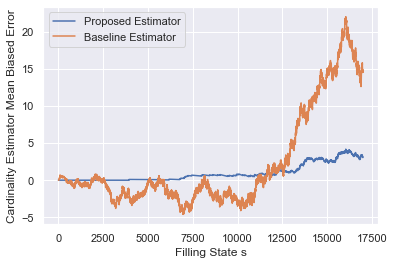

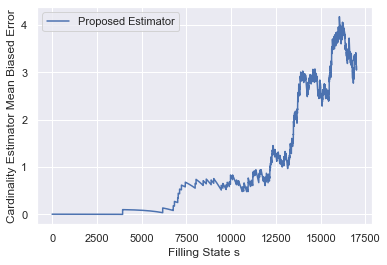

In [239]:
iterations = np.arange(max_items+1)

# Erreur moyenne des compteurs corrigés
plt.figure()
plt.plot(iterations, mean_count_corrected_errors, label = 'Proposed Estimator')
plt.plot(iterations, mean_literature_estimator_errors, label = 'Baseline Estimator')
plt.xlabel('Filling State s')
plt.ylabel('Cardinality Estimator Mean Biased Error')
plt.legend()
plt.show()

# Erreur moyenne des compteurs corrigés : sans la littérature
plt.figure()
plt.plot(iterations, mean_count_corrected_errors, label = 'Proposed Estimator')
plt.xlabel('Filling State s')
plt.ylabel('Cardinality Estimator Mean Biased Error')
plt.legend()
plt.show()

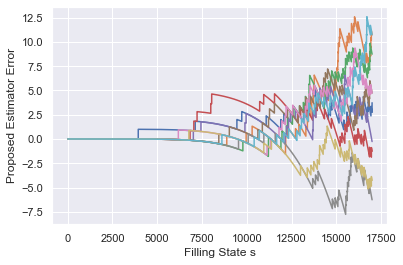

In [240]:
# Tous les tirages
plt.figure()
for t in range(n_t):
     plt.plot(iterations, resultats_tirages[t][3])
plt.xlabel('Filling State s')
plt.ylabel('Proposed Estimator Error')
plt.show()

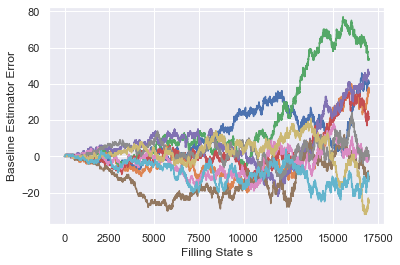

In [241]:
# Tous les tirages
plt.figure()
for t in range(n_t):
     plt.plot(iterations, resultats_tirages[t][4])
plt.xlabel('Filling State s')
plt.ylabel('Baseline Estimator Error')
plt.show()

### Distribution de l'erreur autour de la moyenne

In [456]:
df_ecart_estimateur = pd.DataFrame()
for t in range(n_t):
    df_ecart_estimateur[f'Tirage_{t}'] = resultats_tirages[t][3]

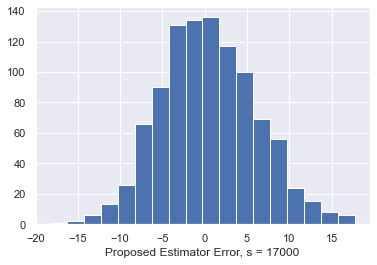

In [457]:
plt.figure()
df_ecart_estimateur.loc[17000].hist(bins = 18)
plt.xlabel('Proposed Estimator Error, s = 17000')
plt.show()

In [458]:
df_ecart_estimateur2 = pd.DataFrame()
for t in range(n_t):
    df_ecart_estimateur2[f'Tirage_{t}'] = resultats_tirages[t][4]

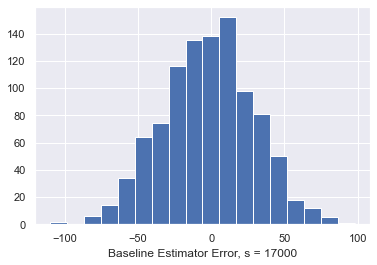

In [459]:
plt.figure()
df_ecart_estimateur2.loc[17000].hist(bins = 18)
plt.xlabel('Baseline Estimator Error, s = 17000')
plt.show()

### Ecart type estimateurs

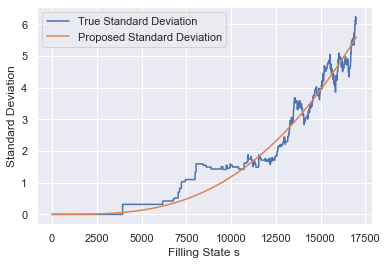

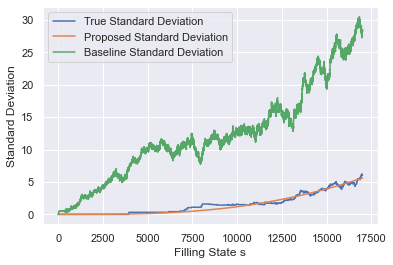

In [242]:
# Ecart type de l'erreur de comptage : on compare l'ecart type de l'estimateur, et l'écart type de l'erreur réelle sur tous les tirages
iterations = np.arange(max_items+1)
plt.figure()
plt.plot(iterations, std_count_errors, label = 'True Standard Deviation') # Ecart type des tirages (estimateur non biaisé de l'écart type)
plt.plot(iterations, np.array(std_error_count)[iterations], label = 'Proposed Standard Deviation') # Ecart type estimé
plt.xlabel('Filling State s')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

plt.figure()
plt.plot(iterations, std_count_errors, label = 'True Standard Deviation') # Ecart type des tirages (estimateur non biaisé de l'écart type)
plt.plot(iterations, np.array(std_error_count)[iterations], label = 'Proposed Standard Deviation') # Ecart type estimé
plt.plot(iterations, std_litterature_errors, label = 'Baseline Standard Deviation') # Ecart type estimé
plt.xlabel('Filling State s')
plt.ylabel('Standard Deviation')
plt.legend(loc = 'upper left')
plt.show()

### Violin plots : erreur moyenne et distribution

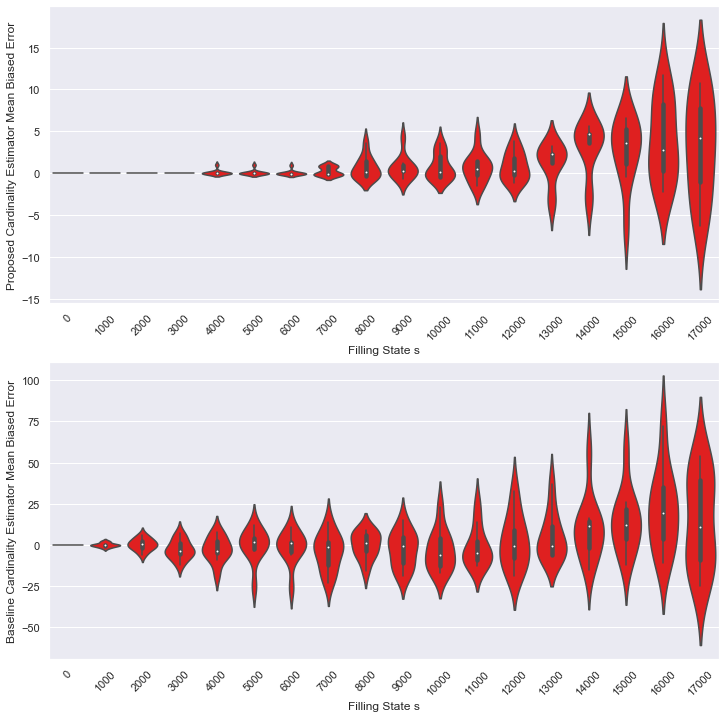

In [243]:
count_corrected_errors_violin = count_corrected_errors[:, ::1000].T.ravel()
litterature_errors_violin = litterature_errors[:, ::1000].T.ravel()
iterations_violin = np.repeat(iterations[::1000], n_t)
data_violin1 = pd.DataFrame({'Filling State s':iterations_violin, 'Proposed Cardinality Estimator Mean Biased Error':count_corrected_errors_violin})
data_violin2 = pd.DataFrame({'Filling State s':iterations_violin, 'Baseline Cardinality Estimator Mean Biased Error':litterature_errors_violin})

plt.figure(figsize = (12, 12))
ax1 = plt.subplot(211)
ax1 = sns.violinplot(x="Filling State s", y="Proposed Cardinality Estimator Mean Biased Error", data = data_violin1, scale = 'width', color = 'red')
plt.xticks(rotation = 45)

ax2 = plt.subplot(212, sharex = ax1)
ax2 = sns.violinplot(x="Filling State s", y="Baseline Cardinality Estimator Mean Biased Error", data = data_violin2, scale = 'width', color = 'red')
plt.xticks(rotation = 45)
plt.savefig('Violin_1par1_p=1.png', format = 'png')
plt.show()

In [120]:
BFs[1].bit_array.count(1)/BFs[0].size # Taux de bits à 1, environ 50% ?

0.4660100033753721

In [4]:
def remplissage_batch_unique(BF, elements, batch_size):

    # Compteurs d'éléments au cours du temps
    count_unique_elements = [0] # Notre compteur pas corrigé
    literature_estimate_count = [0]
    corrected_counter = [0] # Compteur corrigé

    # Nombre d'éléments oubliés (faux positifs)
    error_on_count = [0]

    # Erreur des estimateurs
    error_corrected_counter = [0]
    error_literature_estimate = [0]
    
    # Espérance / Variance du nombre de faux positifs : somme incrémentale
    var_fp_sum = [0]
    esp_fp_sum = [0]

    # Ajout des éléments dans le filtre, un par un
    i = 0
    while BF.unique_items < 17000:
        # Calcul espérance et variance du nombre de faux positifs à ce changement d'état
        fp_prob = BF.get_fp_prob(BF.unique_items, BF.size, BF.hash_count)
        esp_fp = fp_prob/(1-fp_prob) + (batch_size-1)*fp_prob
        var_fp = (fp_prob/(1-fp_prob))**2 + (batch_size-1)*fp_prob*(1-fp_prob)
        esp_fp_sum.append(esp_fp_sum[-1] + esp_fp)
        var_fp_sum.append(var_fp_sum[-1] + var_fp)
        
        batch_elements = elements[i:i+batch_size]
        BF.add_items(batch_elements) # Ajout des éléments (modifie le filtre seulement si check negatif)
        if BF.unique_items == count_unique_elements[-1]: # On en a ajouté aucun
            error_on_count[-1] += batch_size # On en a oublié 1000 d'un coup, le niveau de remplissage n'a pas changé, mais l'erreur a augmenté.
        else: # On a oublié d'en ajouter (ou non) : erreurs (ou non).
            error_on_count.append(error_on_count[-1] + (batch_size - BF.unique_items + count_unique_elements[-1])) # Niveau de remplissage change et erreur augmente.
            count_unique_elements.append(BF.unique_items)
            literature_estimate_count.append(BF.estimate_items)
            
            # Correction des compteurs
            corrected_counter.append(count_unique_elements[-1] + esp_fp_sum[-1]) # On ajoute l'estimateur qu'on a fait pour corriger l'erreur de comptage
            error_corrected_counter.append(i+batch_size - corrected_counter[-1])
            error_literature_estimate.append(i+batch_size - literature_estimate_count[-1])
        i += batch_size
    
    return count_unique_elements, literature_estimate_count, error_on_count, error_corrected_counter, error_literature_estimate, var_fp_sum

In [106]:
# On fait n_t tirages aléatoires (parmi des entiers) d'entiers non uniques, assez pour mettre 10 000 uniques dans le filtre
n_t = 10
batch_size = 100
tirages_elements = np.array([np.array(random.sample(range(100000), k = 20000)) for t in range(n_t)])

# On fait n_t copies du filtre de bloom
BFs = [copy.deepcopy(BF) for t in range(n_t)]

In [6]:
resultats_tirages2 = []
for t in range(n_t):
    resultats_tirages2.append(remplissage_batch_unique(BFs[t], tirages_elements[t, :], batch_size))
    
min_len_results = min([len(resultats_tirages2[t][0]) for t in range(n_t)])
max_len_results = max([len(resultats_tirages2[t][0]) for t in range(n_t)])
resultats_tirages = np.zeros(shape = (n_t, 6, min_len_results))

for t in range(n_t):
    for y in range(6):
        resultats_tirages[t, y] = resultats_tirages2[t][y][0:min_len_results]

In [8]:
print(min_len_results, max_len_results)

1704 1706


### Création univers et des esimateurs (espérance / variance)

In [107]:
def creation_univers_estimateurs_batch(n_t, batch_size, max_items, BF):

    # Création univers
    #U = creation_univers(max_items, 0.01, n_t)
    #U = creation_univers(max_items, 0.2, n_t)
    #U = creation_univers(max_items, 0.4, n_t)
    #U = creation_univers(max_items, 0.6, n_t)
    U = creation_univers(max_items, 0.8, n_t)
    #U = creation_univers(max_items, 0.99, n_t)

    # Création des estimateurs
    population_estimation = [0]
    mean_error_count, var_error_count = [0], [0]

    fp_probs = BF.get_fp_prob(np.arange(0, max_items + batch_size + 1), BF.size, BF.hash_count)
    prior_prob = np.array([1 - s/U.shape[1] for s in range(0, max_items + 1)])

    while population_estimation[-1] < max_items:

        # Grandeurs utiles
        alpha1 = prior_prob[population_estimation[-1]]*(1-fp_probs[population_estimation[-1]]) # pi(1-ti)
        alpha2 = prior_prob[population_estimation[-1]]*fp_probs[population_estimation[-1]] # piti
        alpha3 = 1/(1-(1-alpha1)**batch_size) # 1/(1-alphai^b) article

        mean_error_count.append(mean_error_count[-1] + batch_size*alpha2*alpha3)
        var_error_count.append(var_error_count[-1] + batch_size*alpha2*(1-alpha2)*alpha3)
        population_estimation.append(population_estimation[-1] + int(round(batch_size*alpha1*alpha3)))
    std_error_count = np.sqrt(var_error_count)
    
    return U, population_estimation, np.array(mean_error_count), std_error_count

In [108]:
# Estimateur de l'erreur de comptage et variance associée : SANS BATCH, pour comparer
mean_error_count_sb, var_error_count_sb = [0], [0]
for l in range(2*max_items):
    mean_error_count_sb.append(np.sum((fp_probs/(1-fp_probs))[:l+1])) # Temps d'attente (loi géométrique)
    var_error_count_sb.append(np.sum((fp_probs/((1-fp_probs)**2))[:l+1])) # Variance loi géométrique
mean_error_count_sb = np.array(mean_error_count_sb)
std_error_count_sb = np.sqrt(var_error_count_sb)

In [135]:
n_t = 10
batch_size = 100

U, population_estimation, mean_error_count, std_error_count = creation_univers_estimateurs_batch(n_t, batch_size, max_items, BF)

In [118]:
mean_error_count.shape

(191,)

In [120]:
len(population_estimation)

191

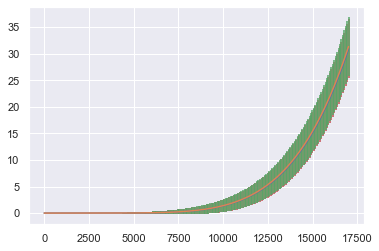

In [110]:
# Visualisation des estimateurs : errorbar
plt.figure()
plt.errorbar(population_estimation, mean_error_count, std_error_count, \
             ecolor = 'r')

plt.errorbar(np.arange(0, max_items+batch_size)[population_estimation], mean_error_count_sb[population_estimation], std_error_count_sb[population_estimation], \
             ecolor = 'g')
plt.show()

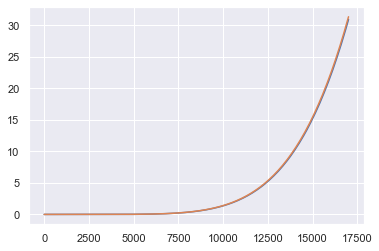

In [111]:
# Visualisation des estimateurs : errorbar
plt.figure()
plt.plot(population_estimation, mean_error_count)

plt.plot(np.arange(0, max_items+batch_size)[population_estimation], mean_error_count_sb[population_estimation])
plt.show()

In [112]:
mean_error_count.shape

(191,)

### Remplissage des filtres

In [163]:
def remplissage_batch_tirage(BF, elements, estimateur, batch_size, max_items):
    
    # Compteurs d'éléments au cours du temps
    count_unique_elements = [0] # Notre compteur pas corrigé
    literature_estimate_count = [0]
    corrected_counter = [0] # Compteur corrigé

    # Nombre d'éléments oubliés (faux positifs)
    error_on_count = [0]

    # Erreur des estimateurs
    error_corrected_counter = [0]
    error_literature_estimate = [0]
    
    # Ajout des éléments dans le filtre, par batch, avec tirage uniforme dans l'univers
    elements_seen = []
    i, j = 0, 0
    while BF.unique_items < max_items:
        batch_elements = np.array(random.sample(elements, batch_size))
        checks = BF.check_items(batch_elements)
        positives = batch_elements[checks]
        true_negatives = batch_elements[~checks]
        false_positives = positives[~np.isin(positives, elements_seen)]
        if len(true_negatives) == 0: # Pas de négatif, on ne change pas d'état, mais l'erreur augmente
            error_on_count[-1] += len(false_positives)
        else: # Le niveau de remplissage change
            BF.add_items(true_negatives) # On peut ajouter uniquement les true negatives ici, pour gagner un peu de temps
            count_unique_elements.append(BF.unique_items)
            literature_estimate_count.append(BF.estimate_items)
            error_on_count.append(error_on_count[-1] + len(false_positives))
            corrected_counter.append(count_unique_elements[-1] + estimateur[j])
            error_corrected_counter.append(i + len(true_negatives) + len(false_positives) - corrected_counter[-1])
            error_literature_estimate.append(i + len(true_negatives) + len(false_positives) - literature_estimate_count[-1])
        i += len(true_negatives) + len(false_positives)
        j += 1
        elements_seen = np.append(elements_seen, batch_elements[~np.isin(batch_elements, elements_seen)])
        
    return count_unique_elements, literature_estimate_count, error_on_count, error_corrected_counter, error_literature_estimate   

In [164]:
# On fait n_t copies du filtre de bloom
BFs = [copy.deepcopy(BF) for t in range(n_t)]

resultats_tirages = []
for t in range(n_t):
    resultats_tirages.append(remplissage_batch_tirage(BFs[t], set(U[t, :]), mean_error_count, batch_size, max_items))
#resultats_tirages = np.array(resultats_tirages, dtype = 'object')

In [180]:
len(resultats_tirages[9][0])

192

### Population à chaque changement d'état

In [154]:
resultats_tirages[:, 0 :].mean(axis = 0)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [372]:
resultats_tirages[:, 0, :].std(axis = 0)

array([0.        , 0.        , 0.        , ..., 5.47813837, 5.47813837,
       5.53985559])

In [373]:
(resultats_tirages[:, 0, :].std(axis = 0)[1:]/resultats_tirages[:, 0, :].mean(axis = 0)[1:]).max()

0.00036320758844135466

### Erreur moyenne

In [9]:
# Les erreurs de comptage
count_errors = np.array(resultats_tirages)[:, 2, :]
mean_count_errors = np.mean(count_errors, axis = 0)
std_count_errors = np.sqrt((1/(n_t-1))*np.sum((count_errors - mean_count_errors)**2, axis = 0))

# Les erreurs des compteurs corrigés
count_corrected_errors = np.array(resultats_tirages)[:, 3, :]
mean_count_corrected_errors = np.mean(count_corrected_errors, axis = 0)
std_count_corrected_errors = np.sqrt((1/(n_t-1))*np.sum((count_corrected_errors - mean_count_corrected_errors)**2, axis = 0))

# Les erreurs de baseline
litterature_errors = np.array(resultats_tirages)[:, 4, :]
mean_literature_estimator_errors = np.mean(litterature_errors, axis = 0)
std_litterature_errors = np.sqrt((1/(n_t-1))*np.sum((litterature_errors - mean_literature_estimator_errors)**2, axis = 0))

In [10]:
# Au dernier niveau de remplissage
print('MBE Proposal', mean_count_corrected_errors[-1])
print('Std MBE Proposal', std_count_corrected_errors[-1])
print('MBE Baseline', mean_literature_estimator_errors[-1])
print('Std MBE Baseline', std_litterature_errors[-1])
print('MAE Proposal', np.mean(np.abs(count_corrected_errors), axis = 0)[-1])
print('Std MAE Proposal', np.std(np.abs(count_corrected_errors), axis = 0)[-1])
print('MAE Baseline', np.mean(np.abs(litterature_errors), axis = 0)[-1])
print('Std MAE Baseline', np.std(np.abs(litterature_errors), axis = 0)[-1])
print('RMSE Proposal', np.sqrt(np.mean(count_corrected_errors**2, axis = 0))[-1])
print('RMSE Baseline', np.sqrt(np.mean(litterature_errors**2, axis = 0))[-1])

MBE Proposal 2.08501349443286
Std MBE Proposal 4.589630783658748
MBE Baseline 1.3
Std MBE Baseline 28.000198411995424
MAE Proposal 3.7154621909179695
Std MAE Proposal 3.082346774310669
MAE Baseline 22.5
Std MAE Baseline 14.179210133149168
RMSE Proposal 4.8275791996863555
RMSE Baseline 26.59511233290809


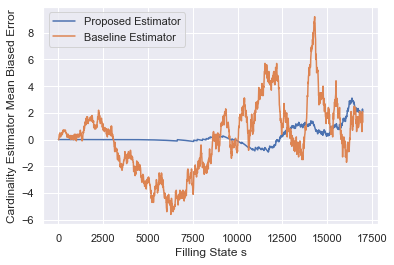

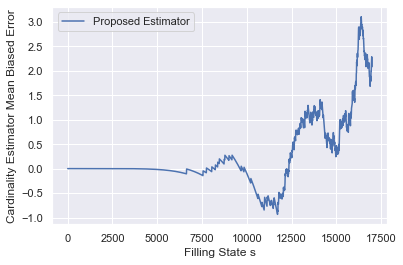

In [11]:
iterations = resultats_tirages[:, 0, :].mean(axis = 0)

# Erreur moyenne des compteurs corrigés
plt.figure()
plt.plot(iterations, mean_count_corrected_errors, label = 'Proposed Estimator')
plt.plot(iterations, mean_literature_estimator_errors, label = 'Baseline Estimator')
plt.xlabel('Filling State s')
plt.ylabel('Cardinality Estimator Mean Biased Error')
plt.legend()
plt.show()

# Erreur moyenne des compteurs corrigés : sans la littérature
plt.figure()
plt.plot(iterations, mean_count_corrected_errors, label = 'Proposed Estimator')
plt.xlabel('Filling State s')
plt.ylabel('Cardinality Estimator Mean Biased Error')
plt.legend()
plt.show()

### Ecart type estimateurs

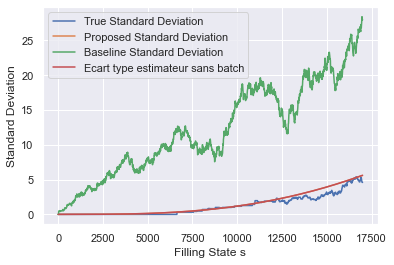

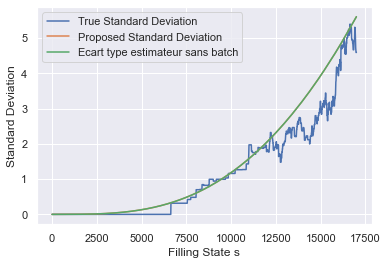

In [19]:
population = resultats_tirages[:, 0, :].mean(axis = 0).astype(int)

# Erreur moyenne des compteurs corrigés
plt.figure()
plt.plot(iterations, std_count_corrected_errors, label = 'True Standard Deviation')
plt.plot(iterations, std_error_count[population], label = 'Proposed Standard Deviation') # Ecart type estimé
plt.plot(iterations, std_litterature_errors, label = 'Baseline Standard Deviation')
plt.plot(iterations, np.array(std_error_count)[population], label = 'Ecart type estimateur sans batch')
plt.xlabel('Filling State s')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()


# Erreur moyenne des compteurs corrigés
plt.figure()
plt.plot(iterations, std_count_corrected_errors, label = 'True Standard Deviation')
plt.plot(iterations, std_error_count[population], label = 'Proposed Standard Deviation') # Ecart type estimé
#plt.plot(iterations, std_litterature_errors, label = 'Baseline Standard Deviation')
plt.plot(iterations, np.array(std_error_count)[population], label = 'Ecart type estimateur sans batch')
plt.xlabel('Filling State s')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

In [376]:
count_corrected_errors.shape

(10, 1704)

### Violin plots : erreur moyenne et distribution

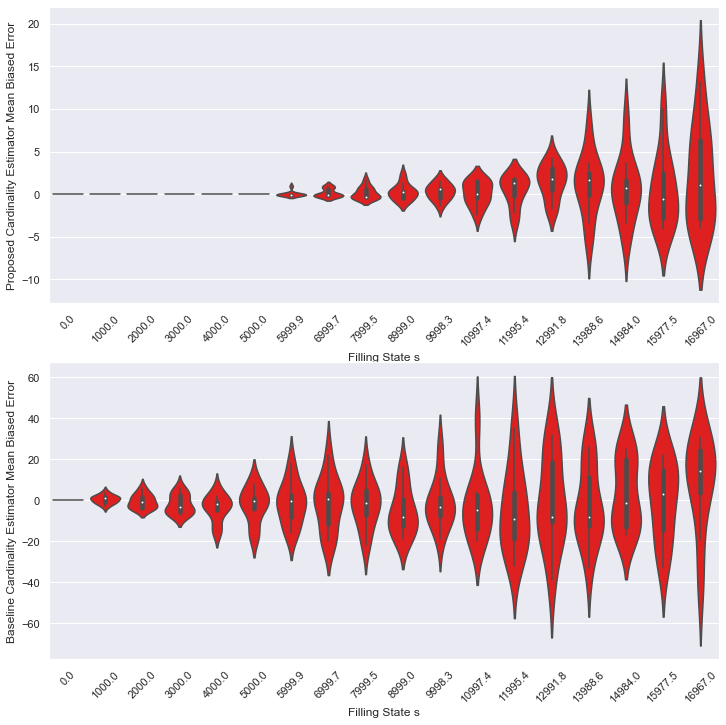

In [378]:
count_corrected_errors_violin = count_corrected_errors[:, ::100].T.ravel()
litterature_errors_violin = litterature_errors[:, ::100].T.ravel()
iterations_violin = np.repeat(iterations[::100], n_t)
data_violin1 = pd.DataFrame({'Filling State s':iterations_violin, 'Proposed Cardinality Estimator Mean Biased Error':count_corrected_errors_violin})
data_violin2 = pd.DataFrame({'Filling State s':iterations_violin, 'Baseline Cardinality Estimator Mean Biased Error':litterature_errors_violin})

plt.figure(figsize = (12, 12))
ax1 = plt.subplot(211)
ax1 = sns.violinplot(x="Filling State s", y="Proposed Cardinality Estimator Mean Biased Error", data = data_violin1, scale = 'width', color = 'red')
plt.xticks(rotation = 45)

ax2 = plt.subplot(212, sharex = ax1)
ax2 = sns.violinplot(x="Filling State s", y="Baseline Cardinality Estimator Mean Biased Error", data = data_violin2, scale = 'width', color = 'red')
plt.xticks(rotation = 45)
#plt.savefig('Violin_1par1_p=1.png', format = 'png')
plt.show()